# kulprit: Kullback-Leibler projections for Bayesian model selection in Python

## Introduction to projection predictive model selection

The Bayesian community has recently witnessed a rapid growth in theoretical and applied contributions to building and selecting predictive models. Projection predictive inference, based on the ideas of Goutis and Robert (1998) and Dupuis and Robert (2003), in particular has shown promise in doing so, finding application in medical statistics and deep learning. It is less prone to over-fitting than naïve selection based purely on cross-validated performance metrics, and has been known to out-perform the maximum _a posteriori_ model in terms of predictive performance.

## Data

For this tutorial we will use some simple simulated data following a Gaussian observation model. We simulate $n = 100$ samples from $p = 10$ covariates of which $5$ are informative using `sklearn`.

In [30]:
from scipy.stats import wishart
import pandas as pd
pd.set_option('display.max_columns', 7)
import numpy as np

# generate the data
n, p = 100, 10
rv = wishart(df=p+1, scale=np.ones(p))
cov = rv.rvs()
X = np.random.multivariate_normal(np.zeros(p), cov, size=n)
beta = np.ones(p) * 0.1
y = X @ beta + np.random.normal(loc=0.0, scale=1.0, size=n)
data = np.append(X, y[:, None], axis=1)
covnames = [f"x{x}" for x in range(p)]
df = pd.DataFrame(data, columns=covnames + ["y"])
df.head()

,x0,x1,x2,...,x8,x9,y
0,1.699117,0.349756,-2.258060,...,-0.508544,-1.488765,-0.429603
1,-2.197462,-6.432639,2.918589,...,6.337288,-2.559108,-0.178579
2,-4.182656,0.887224,0.663901,...,4.315193,0.007157,-0.156251
3,6.940319,-1.165621,-2.064801,...,-7.801437,-1.132701,-2.152939
4,1.282403,5.070650,2.367716,...,-2.503487,0.725924,0.656936


## Reference model

First, we have to construct a reference model for the projection predictive variable selection. This model is considered as the best (“reference”) solution to the prediction task. The aim of the projection predictive variable selection is to find a subset of a set of candidate predictors which is as small as possible but achieves a predictive performance as close as possible to that of the reference model.

The rich reference model is a model we consider to be good in terms of predictive performance, and one we would be happy using as-is. Model selection then becomes applicable when we
1. have a predictive rich model, but would like to reduce computational burden,
2. would like to use a model more robust to changes in the data-generating distribution, or
3. would like to gain a better understanding of important correlation structures.

`kulprit` requires the `arviz.InferenceData` object associated with a fitted `bambi` reference model, as well as the `bambi.Model` object. This `Model` will define the search space in the projection predictive model selection procedure, and the `InferenceData` provides the posterior predictive distribution to emulate. In general, the `InferenceData` need not come from the `Model` object. In other words, `kulprit` naturally allows for the reference model to be different from the search space, affording the statistician the possibility to fit a non-parametric reference model but search through an interpretable space. For the sake of this demonstration, we will only consider nested submodels of the reference model.

In [25]:
import bambi as bmb
import arviz as az

# fit the reference model
priors = {cov: bmb.Prior("Normal", mu=0.0, sigma=1.0) for cov in covnames}
model = bmb.Model(f"y ~ {' + '.join(covnames)}", df, family="gaussian")
idata = model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Note that for model selection, **we require the `kwargs` argument to add the log-likelihood of the reference model to its `idata`**!!!

We combine these object into a `kulprit.ReferenceModel` object as follows:

In [26]:
import kulprit as kpt

# intiate reference model
ref_model = kpt.ReferenceModel(model, idata)

## Model selection

Model selection in our case broadly consists of two components: the _search_ component and the _projection_ component.

### Projection

In essence, the "projection" stage of our model selection procued is achieved by fitting to the fit of the reference model. 

Denote $\theta$ the parameters of the reference model, and $\theta_\perp$ those of some submodel. We are primarily interested in inferring submodel parameter values that optimise for prediction. In the original formulation by Goutis and Robert (1998), one looks to replace some reference model's posterior, denoted $p(\theta\mid \mathcal{D})$ herein, with some restricted posterior $q(\theta_\perp)$ such that their induced posterior predictive distributions, $p(\tilde{y} \mid \theta, \mathcal{D})$ and $q(\tilde{y}\mid\theta_\perp)$, are as similar as possible. This similarity is quantified by Kullback-Leibler distance (KL; Kullback and Leibler, 1951). Formally, we aim to produce this restricted posterior $q(\theta_\perp)$ such that

$$
q(\theta_\perp) = {\arg\,\min}_{q\in\mathscr{Q}(\Theta)} \mathbb{KL}\{p(\tilde{y}\mid\theta, \mathcal{D}) \mid q(\tilde{y})\}.
$$

### Search

We currently account for two main methods of search: forward search, and Lasso-type search ($L_1$ search). We recommend that users favour forward search over $L_1$ search when searching up to $40$ covariates as it broadly produces "better" solution paths (by which we mean less selection-induced over-fitting).

In forward search, we begin by projecting the reference model onto the "empty" (intercept-only) model, which acts as the root of our search tree. We then project the reference model onto all models with one predictor and the intercept term, and select the single-predictor model whose posterior predictive distribution is closest to the reference model's posterior predictive distribution (possibly coarsened by clustering or thinning the posterior draws) in KL divergence sense and as defined in Section~\ref{sec:projpred}. Denote this first predictor to be selected $x^{(1)}$. Following this, we fit all size-two models including the intercept and $x^{(1)}$ (``size-two'' does not count the intercept here), and once more select the one closest to the reference model in terms of KL divergence of their posterior predictive distributions. Denote this second predictor to be selected $x^{(2)}$. This is repeated until either all predictors are selected, or some pre-defined limit on the model size is reached. Our solution path is then the list of predictors ordered by the stage at which they were selected: in our example $(\text{Intercept}, x^{(1)},x^{(2)},\dotsc)$. 

Tangentially, $L_1$ search can reduce computational cost by fitting a model with Lasso penalty to the in-sample predictions made by the reference model (thus, the $L_1$ search solves an $L_1$-penalised projection problem, whereas the forward search solves the original projection problem) and investigating the order in which the predictors enter the Lasso model.

In [29]:
ref_model.search(method="forward")

ValueError: min() arg is an empty sequence

### Model size selection

We now do not reason directly on the submodels, but rather their sizes. That is to say that we presently look to select the smallest submodel size, say $k$, such that

$$
k = {\arg\,\min}_{k=1,\dotsc,p_\text{max}} \left\{  \right\}
$$

/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/yannmclatchie/Deskt

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
10,0,-144.768040,11.074187,0.000000,0.672893,7.205273,0.000000,False,log
3,1,-145.610787,10.048673,0.842747,0.327107,7.541875,2.243628,True,log
4,2,-147.337071,12.324956,2.569032,0.000000,7.571955,1.987422,True,log
5,3,-148.735823,13.728220,3.967783,0.000000,7.821317,2.036561,False,log
6,4,-151.574983,16.879502,6.806943,0.000000,7.983922,1.755028,True,log
7,5,-156.096329,21.630274,11.328289,0.000000,8.892048,2.382780,True,log
8,6,-158.017003,23.966065,13.248964,0.000000,9.107283,2.095473,True,log
2,7,-457.274410,0.019536,312.506371,0.000000,7.958641,11.235270,False,log
1,8,-496.260825,0.006159,351.492785,0.000000,7.340056,10.389015,False,log
0,9,-549.373372,0.001506,404.605333,0.000000,6.517828,8.624884,False,log


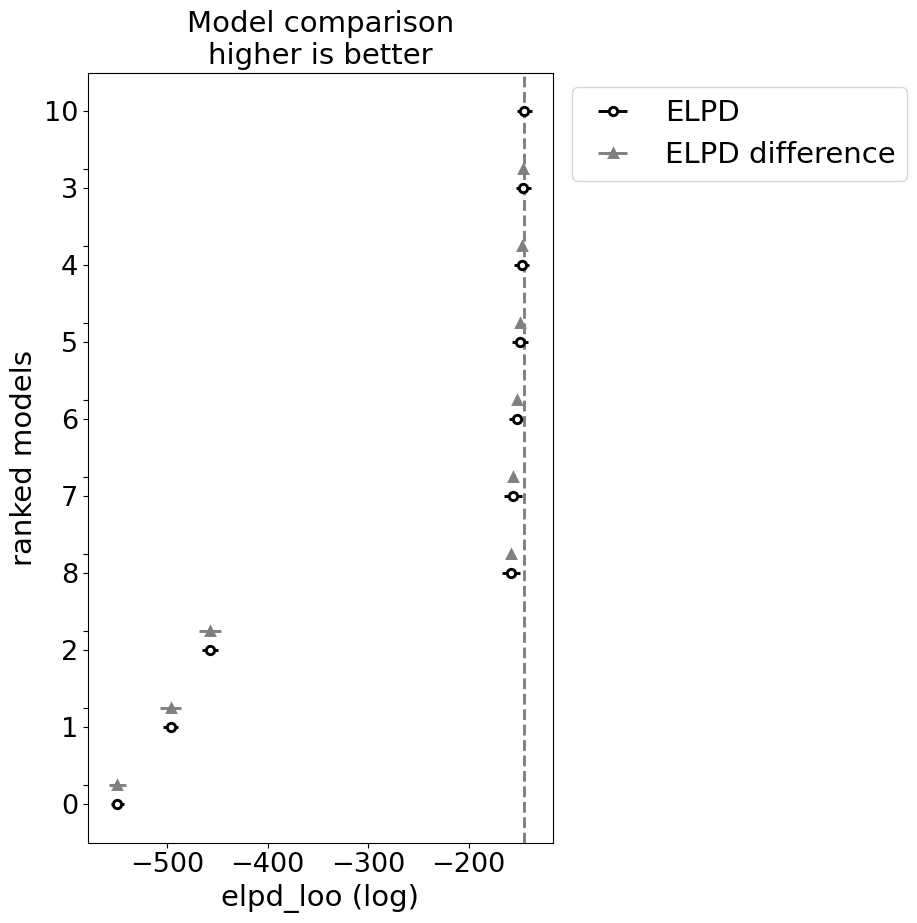

In [78]:
# compare submodels found in the search by LOO-CV ELPD
cmp, ax = ref_model.loo_compare(plot=True, scale="log");
cmp

[^1]: $\tilde{y}$ is random variable sampled from some distribution. We will later see expectations taken with respect to $\tilde{y}$ under some sample distribution $p$, denoted $\mathbb{E}_{\tilde{y}\sim p}[\cdot]$.